## Build & Train Model

### Import Libraries

In [56]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

from itertools import chain
from random import sample 
from datetime import datetime

import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

#from keras.utils.vis_utils import plot_model
#from IPython.display import Image
#from keras.utils.vis_utils import model_to_dot
#from tensorflow import keras

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.models import model_from_json
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
40295,00010496_018.png,Nodule,18,10496,45,M,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010496_018.png
72798,00017944_003.png,Effusion|Infiltration,3,17944,37,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00017944_003.png
90049,00022381_000.png,No Finding,0,22381,64,F,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00022381_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: 'Pneumonia' if x == 1.0 else 'No Pneumonia')

In [5]:
all_xray_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No Pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia


## Create your training and testing data:

In [6]:
all_xray_df[all_xray_df['Pneumonia'] == 1.0].shape[0]

1431

Only Pneumonia cases:

In [7]:
all_xray_df[all_xray_df['Finding Labels'] == 'Pneumonia'].shape[0]

322

There are only 1431 rows where Pneumonia was detected out of total 112120 rows in the dataset. In order to make the model predict Pneumonia, we need to create training and testing data where there is equal representation of Pneumonia in both datasets.

In [104]:
def create_splits(df, test_class):
    '''
    Creates training and testind dataset for model building and training. 
    Ensures that the train/test data is stratified on class being tested.
    
    Input:
    df - dataframe that contains data for model
    test_class - the class that we are trying to predict
    
    Output:
    train_data - training data used for model building
    val_data - validation data for testing model
    '''
    
    # Stratify by 'Pneumonia' class to ensure equal representation in training and test data.
    train_data, val_data = skl.train_test_split(df, test_size = 0.2, stratify = df[test_class])
    
        
    # have EQUAL amount of positive and negative cases of Pneumonia in Training
    # Undersampling
    p_inds = train_data[train_data.Pneumonia==1].index.tolist()
    np_inds = train_data[train_data.Pneumonia==0].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    return train_data, val_data

In [105]:
train_data, val_data = create_splits(all_xray_df, 'Pneumonia')
print(train_data.shape)
print(val_data.shape)

(2290, 29)
(22424, 29)


In [106]:
# check split of positive and negative Pneumonia cases in train dataset
train_data['Pneumonia'].sum()/len(train_data)

0.5

In [107]:
# check split of positive and negative Pneumonia cases in train dataset
val_data['Pneumonia'].sum()/len(val_data)

0.012754191937210132

Performed under sampling in order to have more representation of positive Pneumonia cases in the training dataset.

# Now we can begin our model-building & training

#### Perform some image augmentation on your data

In [108]:
def get_val_standardize(train_df, image_height, image_width, channels):
    '''
    Function to get mean and standard deviation of images from training dataset
    Input:
    train_df - training dataset
    image_height - reshape image to this height
    image_width - reshape image to this height
    channels - reshape image to this channel value
    
    Output:
    mean - mean of pixel data from images in training data
    std - standard deviation of pixel data from images in training data
    
    '''
    # create an empty array
    dataset = np.ndarray(shape=(len(train_df), image_height, image_width, channels), dtype=np.float32)
    i = 0
    
    # loop through each image file
    for i_path in train_data.path:
        # load image
        train_img = load_img(i_path, target_size = (image_height, image_width))
        # convert to numpy array
        img_array = img_to_array(train_img)
        dataset[i] = img_array
        i+=1
    
    #print(dataset.shape)
    
    return np.mean(dataset), np.std(dataset)

Get mean and standard deviation from training dataset.

In [109]:
mean, std = get_val_standardize(train_data, 224, 224, 3)
print("Mean of training data: {}".format(mean))
print("Standard deviation of training data: {}".format(std))

Mean of training data: 124.74175262451172
Standard deviation of training data: 63.49874496459961


In [110]:
def standardize_data(image):
    '''
    Function to standardize image pixels using training data's mean and standard deviation values.
    Input:
    image - Numpy tensor with rank 3
    Output:
    proc_image - Standardized image with same shape as input
    '''
    # standardize image by subtracting mean and dividing by standard deviation
    proc_img = (image - mean)/std
    
    return proc_img

In [111]:
def my_image_augmentation():
    '''
    Augments images from the training and testing dataset by using the keras package.
    
    Input:
    df - dataframe that contains data for model
    test_class - the class that we are trying to predict
    
    Output:
    train_data - training data used for model building
    val_data - validation data for testing model
    '''
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    train_idg = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip = False, 
                                   height_shift_range= 0.05, 
                                   width_shift_range=0.1, 
                                   rotation_range=5, 
                                   shear_range = 0.1,
                                   fill_mode = 'reflect',
                                   zoom_range=0.15,
                                   preprocessing_function = standardize_data
                                   )
    
    val_idg = ImageDataGenerator(preprocessing_function = standardize_data)
    #rescale=1. / 255.0
    
    return train_idg, val_idg


def make_train_gen(train_idg, train_df, img_path, pred_class, IMG_SIZE, size):
    '''
    Creates training and testind dataset for model building and training. 
    Ensures that the train/test data is stratified on class being tested.
    
    Input:
    df - dataframe that contains data for model
    test_class - the class that we are trying to predict
    
    Output:
    train_data - training data used for model building
    val_data - validation data for testing model
    '''
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:

    
    train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                             directory=None, 
                                             x_col = img_path,
                                             y_col = pred_class,
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = size
                                             )
    return train_gen


def make_val_gen(val_idg, valid_df, img_path, pred_class, IMG_SIZE, size):
    '''
    Creates training and testind dataset for model building and training. 
    Ensures that the train/test data is stratified on class being tested.
    
    Input:
    df - dataframe that contains data for model
    test_class - the class that we are trying to predict
    
    Output:
    train_data - training data used for model building
    val_data - validation data for testing model
    '''
    
    # Todo
    val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = img_path,
                                         y_col = pred_class,
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = size
                                         )
    
    return val_gen

In [112]:
train_idg, val_idg = my_image_augmentation()

In [113]:
IMG_SIZE = (224, 224)
train_gen = make_train_gen(train_idg, train_data, 'path', 'pneumonia_class', IMG_SIZE, 100)

Found 2290 validated image filenames belonging to 2 classes.


In [114]:
val_gen = make_val_gen(val_idg, val_data, 'path', 'pneumonia_class', IMG_SIZE, 1024)

Found 22424 validated image filenames belonging to 2 classes.


In [115]:
## Pull a single large batch of random validation data for testing after each epoch:
valX, valY = next(val_gen)

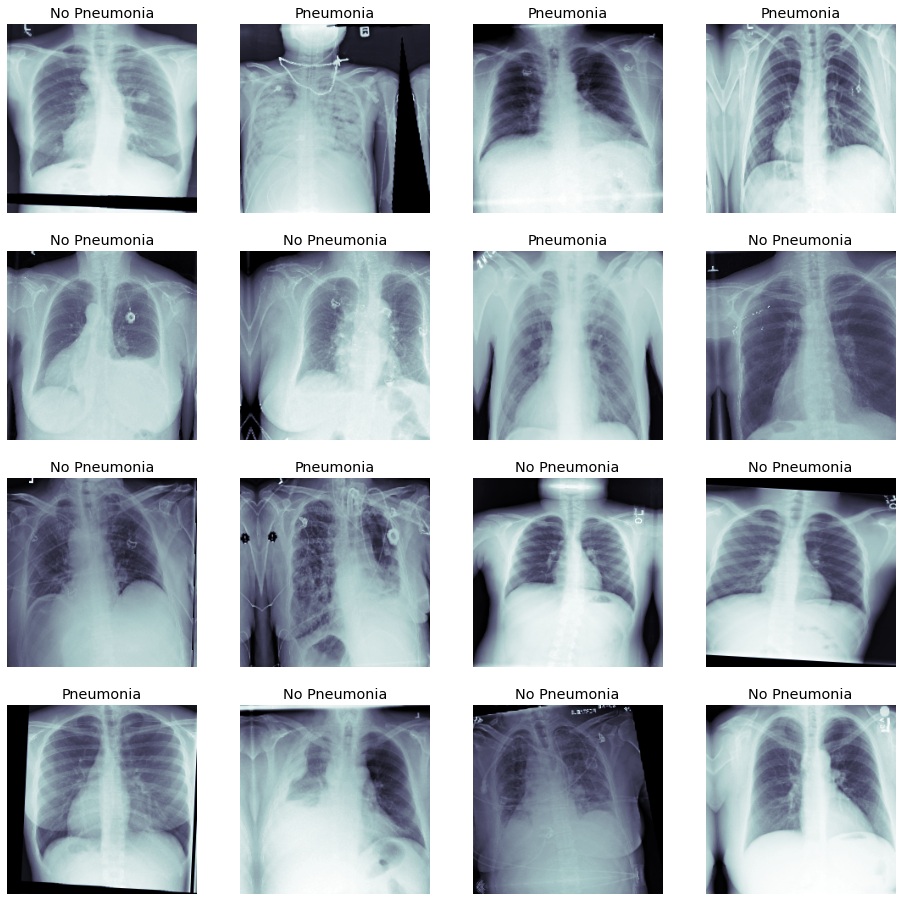

In [116]:
## Look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [117]:
def load_pretrained_model(lay_of_interest):
    '''
    Function to load pre-trained VGG16 model
    
    Input:
    lay_of_interest - transfer layer in the model
    Output:
    vgg_model - pretrained model
    '''
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    model = VGG16(include_top=True, weights='imagenet')
    #model.summary()
    
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
      
    return vgg_model


In [118]:
def build_my_model(lay_of_interest):
    '''
    Funtion to build the model including pretrianed model. Adds additional layers for fine-tuning, compiles the model,
    freezed pre-trained layers and sets the optimizer, loss function and metrics to monitor.
    
    Input:
    lay_of_interest - transfer layer in the model
    
    Output:
    new_model - compiled model
    '''
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    
    # Load pre-trained model
    vgg_model = load_pretrained_model(lay_of_interest)
    ## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
    ## Here, we'll freeze all but the last convolutional layer
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        
    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())
    
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))


    
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    # compile model
    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    new_model.summary()
    
    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [119]:
## Add checkpoints to the model.

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

# to prevent overfitting, stop the learning after 10 epochs when val_loss value not decreased
early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [120]:
## train your model
my_model = build_my_model('block5_pool')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)              

In [121]:
# First: Run 1 epoch to test the model
history = my_model.fit_generator(train_gen, 
                                 steps_per_epoch = 100,
                                 validation_data = (valX, valY), 
                                 epochs = 10,
                                 callbacks = callbacks_list)

Epoch 1/10
100/100 [==============================] - 271s 3s/step - loss: 0.7176 - binary_accuracy: 0.5601 - val_loss: 0.6808 - val_binary_accuracy: 0.6230

Epoch 00001: val_loss improved from inf to 0.68082, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
100/100 [==============================] - 255s 3s/step - loss: 0.6501 - binary_accuracy: 0.6264 - val_loss: 0.6199 - val_binary_accuracy: 0.6807

Epoch 00002: val_loss improved from 0.68082 to 0.61987, saving model to xray_class_my_model.best.hdf5
Epoch 3/10
100/100 [==============================] - 256s 3s/step - loss: 0.6289 - binary_accuracy: 0.6540 - val_loss: 0.5823 - val_binary_accuracy: 0.7041

Epoch 00003: val_loss improved from 0.61987 to 0.58226, saving model to xray_class_my_model.best.hdf5
Epoch 4/10
100/100 [==============================] - 258s 3s/step - loss: 0.6048 - binary_accuracy: 0.6743 - val_loss: 0.8062 - val_binary_accuracy: 0.4961

Epoch 00004: val_loss did not improve from 0.58226
Epoch 5/10
100/

In [122]:
## Save model architecture to a .json:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [45]:
# model_path = 'my_model.json'
# weight_path = 'xray_class_my_model.best.hdf5'

# # load json and create model
# json_file = open(model_path, 'r')
# model_json = json_file.read()
# json_file.close()
# my_model = model_from_json(model_json)
    
# # load weights into new model
# my_model.load_weights(weight_path)
    
# # Set our optimizer, loss function, and learning rate
# optimizer = Adam(lr=1e-4)
# loss = 'binary_crossentropy'
# metrics = ['binary_accuracy']
    
# my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [123]:
#my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

1024/1024 [==============================] - 9s 9ms/step


In [124]:
def plot_auc(t_y, p_y):
    '''
    Function to plot Roc curve.
    
    Input:
    t_y - true label
    p_y - predicted label
    
    '''
   
    print("AUC Score: {}".format(roc_auc_score(t_y, p_y)))
    
    # plot roc curve
    fpr, tpr, _ = roc_curve(t_y, p_y)
    fig, ax = plt.subplots(1,1, figsize = (5, 5))
    ax.plot(fpr, tpr, 'b.-', label = 'VGG-Model')
    ax.plot(fpr, fpr, 'k-', label = 'Random Guessing')
    #ax.legend(loc = 4)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate');
    
    return


def plot_confusion_mat(t_y, p_y, thresh=0.5):
    '''
    Function to plot confusion matrix.
    Input:
    t_y - true label
    p_y - predicted label
    thresh - threshold for precicted label    
    '''
    
    # confusion matrix
    conf_mat = confusion_matrix(y_true=t_y, y_pred=p_y>thresh)
    print('Confusion matrix:\n', conf_mat)
    
    # plot matrix
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

    
#Also consider plotting the history of your model training:

def plot_history(history):
    '''
    Function to plot history of model training.
    
    Input:
    history - model history object
    '''
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

**Performance metrics:**

1. Roc curve
Sensitivity Vs Specificity

 - Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
 - Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

AUC Score: 0.6716073781291172


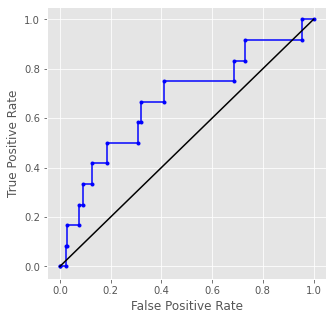

In [125]:
## plot figures
plot_auc(valY, pred_Y)

Since AOC > 0.5, we know our model is performing better than random classifier.

2. Precision-Recall Curve

In [126]:
# plot Precision Recall curve
precision, recall, _ = precision_recall_curve(valY, pred_Y)

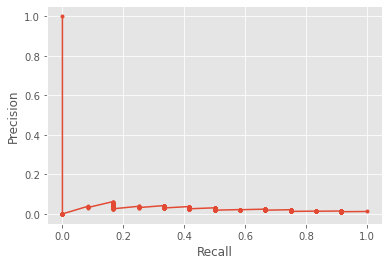

In [127]:
plt.plot(recall, precision, marker='.')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision');

3. Confusion Matrix

Confusion matrix:
 [[811 201]
 [  6   6]]


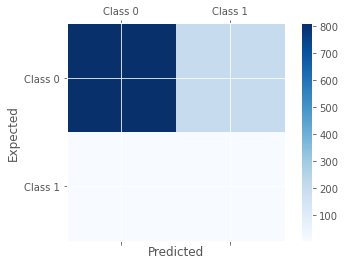

In [132]:
plot_confusion_mat(valY, pred_Y, 0.7)

4. History

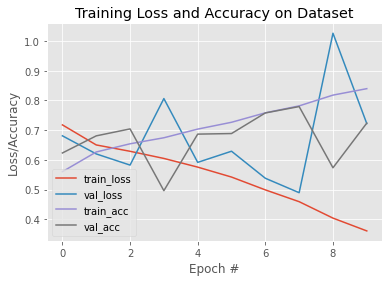

In [130]:
plot_history(history)

Training loss steadily goes down with each epoch. The validation loss decreases by 5th epoch and then starts to increase. The model stops training essentially after the 5th epoch. 
Training accuracy starts to increase post 6th epoch suggesting overfitting.

**Threshold Identification:**

In [33]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

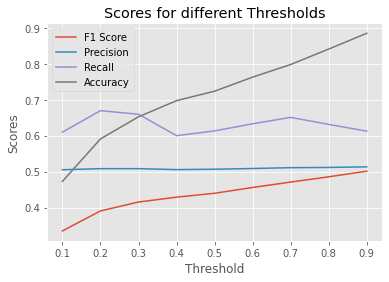

In [131]:
# get f1,precision, recall, accuracy scores for different threshold values
thresh = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
f1_res, pr_res, re_res, ac_res = [], [], [], []

for i in thresh:
    f1_res.append(f1_score(valY, pred_Y>i, average='macro'))
    pr_res.append(precision_score(valY, pred_Y>i, average='macro', zero_division=1))
    re_res.append(recall_score(valY, pred_Y>i, average='macro'))
    ac_res.append(accuracy_score(valY, pred_Y>i))

plt.plot(thresh, f1_res, label='F1 Score')
plt.plot(thresh, pr_res, label='Precision')
plt.plot(thresh, re_res, label='Recall')
plt.plot(thresh, ac_res, label='Accuracy')
plt.title("Scores for different Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.legend();

Precision remains constant while Recall increases till 0.7 and then starts decreasing.
Accuracy here is misleading since the dataset is imbalanced.

**The best threshold for this model is 0.7.**

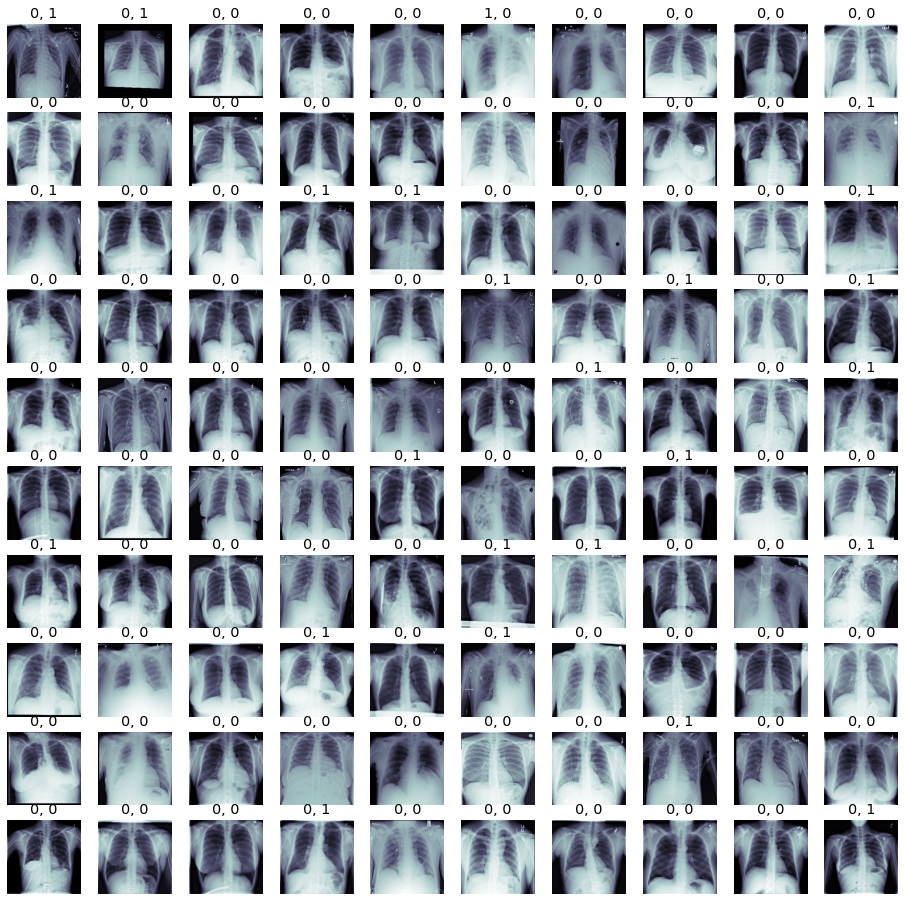

In [133]:
## Let's look at some examples of true vs. predicted with our best model: 

YOUR_THRESHOLD = 0.6

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1